# Autoregressive Models

Ever wondered how financial analysts predict tomorrow's stock prices, how meteorologists forecast next week's weather, or how engineers anticipate system failures before they happen? Welcome to the fascinating world of **autoregressive models** – the mathematical engines that power predictions when the future depends on the past.

In this hands-on example, we'll dive into the elegant framework of Bayesian autoregressive modeling using RxInfer.jl, a powerful probabilistic programming library that makes complex inference tasks surprisingly accessible. Unlike traditional approaches that give you a single prediction, our Bayesian approach provides complete predictive distributions, capturing the uncertainty that's inherent in any real-world forecast.

You'll discover how to:
- Create and understand AR models through a Bayesian lens with RxInfer.jl and `@model` macro
- Generate synthetic data to test your inference algorithms
- Perform automated variational Bayesian inference with RxInfer.jl
- Make probabilistic predictions with quantified uncertainty
- Apply these techniques to real-world stock price data
- As a bonus we implement a simple version of ARMA models

Whether you're predicting financial markets, analyzing sensor readings, modeling climate patterns, or exploring any time-dependent phenomenon, the techniques you'll learn here provide a robust foundation for sophisticated time series analysis using autoregressive models.

## The Mathematics Behind Autoregressive Models

At their core, autoregressive (AR) models capture a fundamental principle: the future depends on the past. But how do we translate this intuition into mathematical precision? Let's build the framework together.

Imagine we're tracking a variable over time - stock prices, temperature readings, or any quantity that evolves sequentially. In an AR model, we express the current value as a function of its previous values, plus some random noise. This elegantly captures both deterministic patterns and inherent uncertainty.

In our Bayesian formulation, we model this process as:

$$\begin{aligned}
p(\gamma) &= \Gamma(\gamma|a, b),\\
p(\mathbf{\theta}) &= \mathcal{N}(\mathbf{\theta}|\mathbf{\mu}, \Sigma),\\
p(x_t|\mathbf{x}_{t-1:t-k}) &= \mathcal{N}(x_t|\mathbf{\theta}^{T}\mathbf{x}_{t-1:t-k}, \gamma^{-1}),\\
p(y_t|x_t) &= \mathcal{N}(y_t|x_t, \tau^{-1}),
\end{aligned}$$

Here's what this means in plain language:
- $x_t$ represents our system's true state at time $t$
- $\mathbf{x}_{t-1:t-k}$ captures the sequence of $k$ previous states
- $\mathbf{\theta}$ holds the "memory coefficients" - how much each past state influences the present
- $\gamma$ controls the randomness in state transitions (higher values mean less randomness)
- $y_t$ is what we actually observe, which includes some measurement noise controlled by $\tau$

It's worth noting that this particular formulation is a **latent autoregressive model**, where the AR process ($x_t$) is hidden behind the likelihood function. In classical AR models, the states are directly observed without this additional observation layer. This latent structure gives us more flexibility in modeling real-world phenomena where measurements contain noise or where the underlying process isn't directly observable.

The beauty of this formulation is that it handles both the "signal" (predictable patterns) and the "noise" (random fluctuations) in a principled way.

For readers interested in the deeper theoretical foundations, we recommend [Albert Podusenko's excellent work on Message Passing-Based Inference for Time-Varying Autoregressive Models](https://www.mdpi.com/1099-4300/23/6/683).

Now, let's translate this mathematical framework into code and see it in action!

In [1]:
using RxInfer, Distributions, LinearAlgebra, Plots, StableRNGs, DataFrames, CSV, Dates

## Starting Simple: From Synthetic to Real-World Data

In our code implementation, we begin by generating synthetic data using predefined sets of coefficients for autoregressive models with orders 1, 2, and 5.

Starting with synthetic data offers several advantages:
- **Ground Truth**: We know the exact coefficients that generated the data, making it possible to evaluate how well our inference algorithms recover these parameters.
- **Control**: We can test our models under different noise levels, sample sizes, and process specifications without the complexity of real-world data.
- **Learning Progression**: By beginning with synthetic examples, we can build intuition about how AR models behave before tackling the messier challenges of real data.

Later in the example, we'll transition to real-world stock price data, where the true generative process is unknown.

In [2]:
# The following coefficients correspond to stable poles
coefs_ar_1 = [-0.27002517200218096]
coefs_ar_2 = [0.4511170798064709, -0.05740081602446657]
coefs_ar_5 = [0.10699399235785655, -0.5237303489793305, 0.3068897071844715, -0.17232255282458891, 0.13323964347539288];

The coefficients we've selected aren't arbitrary - they're carefully chosen to ensure stability in our autoregressive processes. In signal processing and time series analysis, _stable poles_ refer to coefficients that keep the AR process from exploding or diverging over time. Mathematically, this means that the roots of the AR characteristic polynomial must lie inside the unit circle in the complex plane.
For example, in a first-order AR model where $x_t = \theta x_{t-1} + \varepsilon_t$, we need $|\theta| < 1$ to ensure stability. For higher-order models, the constraints become more complex, but the principle remains the same: without stability, our models would produce unrealistic, explosive behavior.

In [3]:
function generate_synthetic_dataset(; n, θ, γ = 1.0, τ = 1.0, rng = StableRNG(42), states1 = randn(rng, length(θ)))
    order = length(θ)

    # Convert precision parameters to standard deviation
    τ_std = sqrt(inv(τ))

    # Initialize states and observations
    states       = Vector{Vector{Float64}}(undef, n + 3order)
    observations = Vector{Float64}(undef, n + 3order)

    # `NormalMeanPrecision` is exported by `RxInfer.jl`
    # and is a part of `ExponentialFamily.jl`
    states[1]       = states1
    observations[1] = rand(rng, NormalMeanPrecision(states[1][1], γ))
    
    for i in 2:(n + 3order)
        previous_state  = states[i - 1]
        transition      = dot(θ, previous_state)
        next_x          = rand(rng, NormalMeanPrecision(transition, τ))
        states[i]       = vcat(next_x, previous_state[1:end-1])
        observations[i] = rand(rng, NormalMeanPrecision(next_x, γ))
    end
    
    return states[1+3order:end], observations[1+3order:end]
end

generate_synthetic_dataset (generic function with 1 method)

We can now generate several synthetic datasets and plot them to see how they look like:

In [4]:
function plot_synthetic_dataset(; dataset, title)
    states, observations = dataset
    p = plot(first.(states), label = "Hidden states", title = title)
    p = scatter!(p, observations, label = "Observations")
    return p
end

plot_synthetic_dataset (generic function with 1 method)

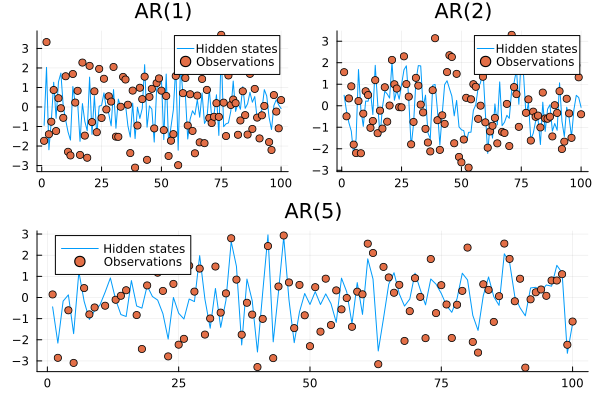

In [5]:
dataset_1 = generate_synthetic_dataset(n = 100, θ = coefs_ar_1)
dataset_2 = generate_synthetic_dataset(n = 100, θ = coefs_ar_2)
dataset_5 = generate_synthetic_dataset(n = 100, θ = coefs_ar_5)

p1 = plot_synthetic_dataset(dataset = dataset_1, title = "AR(1)")
p2 = plot_synthetic_dataset(dataset = dataset_2, title = "AR(2)")
p3 = plot_synthetic_dataset(dataset = dataset_5, title = "AR(5)")

plot(p1, p2, p3, layout = @layout([ a b ; c ]))

## Model Specification: Translating Theory to Code

With our synthetic data ready, we now tackle the critical step of encoding our autoregressive model as a probabilistic program in RxInfer. This translation from mathematical notation to executable code is where the power of probabilistic programming truly shines.

In [6]:
@model function lar_multivariate(y, order, γ)
    # `c` is a unit vector of size `order` with first element equal to 1
    c = ReactiveMP.ar_unit(Multivariate, order)
    
    τ  ~ Gamma(α = 1.0, β = 1.0)
    θ  ~ MvNormal(mean = zeros(order), precision = diageye(order))
    x0 ~ MvNormal(mean = zeros(order), precision = diageye(order))
    
    x_prev = x0
    
    for i in eachindex(y)
 
        x[i] ~ AR(x_prev, θ, τ) 
        y[i] ~ Normal(mean = dot(c, x[i]), precision = γ)
        
        x_prev = x[i]
    end
end

### Constraints specification

Bayesian inference for complex models often requires approximations. Our code uses variational inference with a specific factorization constraint:

In [7]:
@constraints function ar_constraints() 
    q(x0, x, θ, τ) = q(x0, x)q(θ)q(τ)
end

ar_constraints (generic function with 1 method)

This constraint defines how we'll approximate the joint posterior:
- We factorize it into three independent components
- States `(x0, x)` remain jointly distributed, preserving temporal dependencies
- Model parameters `(θ, τ)` are separated from states and each other
- Each component can be updated independently during inference

This factorization balances statistical accuracy with computational efficiency and allows RxInfer to apply efficient message-passing algorithms while maintaining the most important dependencies in the model.

### Meta specification

The @meta block in RxInfer provides essential configuration information to specific nodes in your probabilistic model. In short, it tells RxInfer how to customize inference algorithms, what approximation methods to use, and allows to specify extra computational parameters for custom complex factor nodes. 

In [8]:
@meta function ar_meta(order)
    AR() -> ARMeta(Multivariate, order, ARsafe())
end

ar_meta (generic function with 1 method)

For autoregressive models, this block tells RxInfer:

- Which type of AR process to use (Univariate/Multivariate)
- The order of the process (how many past values influence the current one)
- Any stability constraints to apply during inference

For more information about specific arguments refer to the `AR` node documentation.
For more information on meta blocks, see the [RxInfer.jl documentation](https://docs.rxinfer.com/stable/manuals/meta-specification/).


### Initialization specification

The @initialization block in RxInfer specifies the initial marginal distributions for the model parameters. This is crucial for the convergence of inference algorithms, especially for complex models like autoregressive processes.

For our autoregressive models, we initialize:

In [9]:
@initialization function ar_init(order)
    q(τ) = GammaShapeRate(1.0, 1.0)
    q(θ) = MvNormalMeanPrecision(zeros(order), diageye(order))
end

ar_init (generic function with 1 method)

### Inference

With our model defined, constraints established, and meta configurations in place, we're now at the exciting moment of truth - running Bayesian inference on our latent autoregressive model!

In [10]:
real_θ = coefs_ar_5
real_τ = 0.5
real_γ = 2.0

order = length(real_θ)
n     = 500 

states, observations = generate_synthetic_dataset(n = n, θ = real_θ, τ = real_τ, γ = real_γ)

result = infer(
    model          = lar_multivariate(order = order, γ = real_γ), 
    data           = (y = observations, ),
    constraints    = ar_constraints(),
    meta           = ar_meta(order),
    initialization = ar_init(order),
    options        = (limit_stack_depth = 500, ),
    returnvars     = (x = KeepLast(), τ = KeepEach(), θ = KeepEach()),
    free_energy    = true,
    iterations     = 20
)

Inference results:
  Posteriors       | available for (τ, θ, x)
  Free Energy:     | Real[1575.77, 1261.1, 1056.63, 1011.25, 1001.28, 997.491, 995.92, 995.375, 995.066, 994.961, 994.913, 994.833, 994.899, 994.864, 994.834, 994.894, 994.872, 994.88, 994.897, 994.913]


Now that our inference procedure has completed, we've obtained posterior distributions for all our model parameters and latent states. The AR coefficients, precision parameters, and hidden state sequence have all been inferred from the data, with complete uncertainty quantification.

In [11]:
mean(result.posteriors[:θ][end])

5-element Vector{Float64}:
  0.061826962320093014
 -0.5172296604873058
  0.18038487975628922
 -0.1591736495117488
  0.096603038909771

In [12]:
cov(result.posteriors[:θ][end])

5×5 Matrix{Float64}:
  0.0019919    -9.0483e-5     0.00100443  -0.000263633   0.000309501
 -9.0483e-5     0.00194875   -9.51917e-5   0.000858899  -0.000261436
  0.00100443   -9.51917e-5    0.00241975  -9.69051e-5    0.00100208
 -0.000263633   0.000858899  -9.69051e-5   0.00195085   -9.23067e-5
  0.000309501  -0.000261436   0.00100208  -9.23067e-5    0.00199453

In [13]:
real_θ

5-element Vector{Float64}:
  0.10699399235785655
 -0.5237303489793305
  0.3068897071844715
 -0.17232255282458891
  0.13323964347539288

But numbers alone don't tell the full story. Let's visualize these results to better understand what our model has captured. By plotting the inferred latent states against our observations, we can see how well our model has filtered out the noise to reveal the underlying process dynamics.

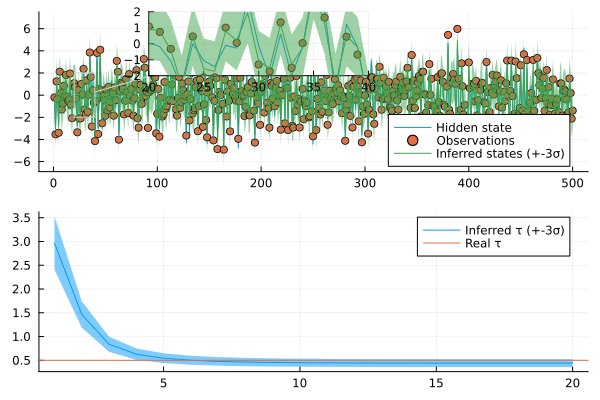

In [14]:
posterior_states       = result.posteriors[:x]
posterior_τ            = result.posteriors[:τ]

p1 = plot(first.(states), label="Hidden state")
p1 = scatter!(p1, observations, label="Observations")
p1 = plot!(p1, first.(mean.(posterior_states)), ribbon = 3first.(std.(posterior_states)), label="Inferred states (+-3σ)", legend = :bottomright)
p1 = lens!(p1, [20, 40], [-2, 2], inset = (1, bbox(0.2, 0.0, 0.4, 0.4)))

p2 = plot(mean.(posterior_τ), ribbon = 3std.(posterior_τ), label = "Inferred τ (+-3σ)", legend = :topright)
p2 = plot!([ real_τ ], seriestype = :hline, label = "Real τ")


plot(p1, p2, layout = @layout([ a; b ]))

When performing variational inference in RxInfer, the Bethe Free Energy (BFE) graph is a crucial diagnostic tool that reveals the convergence properties of our inference algorithm.

The Bethe Free Energy represents the objective function being minimized during variational inference. On the graph:
- The vertical axis shows the BFE value (lower is better)
- The horizontal axis shows iteration number
- The downward slope indicates the algorithm is improving its approximation
- A plateau signals convergence - the point where additional iterations yield minimal improvement

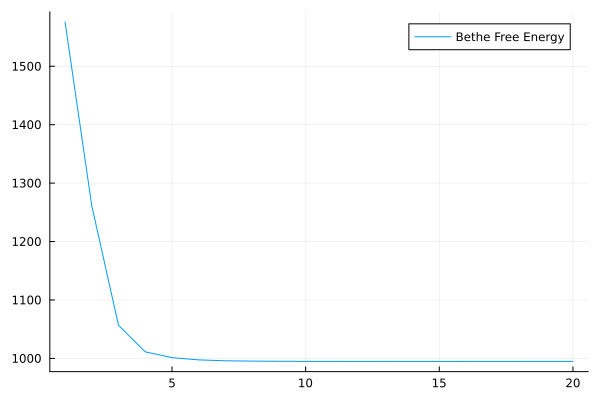

In [15]:
plot(result.free_energy, label = "Bethe Free Energy")

For autoregressive models specifically, the BFE graph helps us:
- Confirm convergence: Ensuring our parameter and state estimates are reliable
- Detect inference challenges: Slow convergence may indicate model misspecification
- Compare models: Different AR orders or constraints can be compared by their final BFE values

A sharply decreasing curve that quickly plateaus suggests efficient, successful inference In contrast, a slowly decreasing or unstable curve might indicate challenges with our model specification or data characteristics.

It is also interesting to plot the convergence of our AR coefficients:

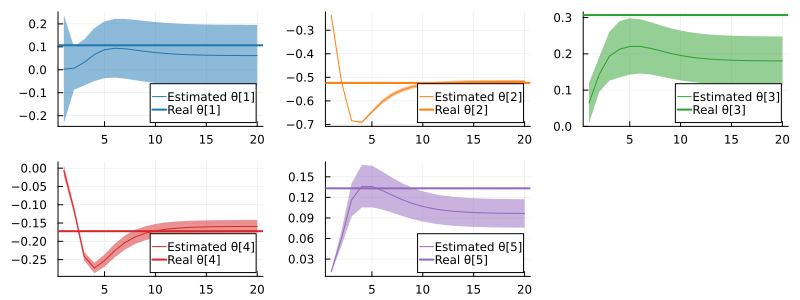

In [16]:
posterior_coefficients = result.posteriors[:θ]

pθ = []
cθ = Plots.palette(:tab10)

θms = mean.(posterior_coefficients)
θvs = 3std.(posterior_coefficients)

for i in 1:length(first(θms))
    push!(pθ, plot(getindex.(θms, i), ribbon = getindex.(θvs, i), label = "Estimated θ[$i]", color = cθ[i]))
end

for i in 1:length(real_θ)
    plot!(pθ[i], [ real_θ[i] ], seriestype = :hline, label = "Real θ[$i]", color = cθ[i], linewidth = 2)
end

plot(pθ..., size = (800, 300), legend = :bottomright)

The inference process has successfully recovered the key parameters of our autoregressive model with good precision. Looking at the plots, we can see well-formed posterior distributions for both our AR coefficients (θ) and precision parameters (τ). The visualization reveals not just point estimates, but complete distributions that capture the remaining uncertainty in each parameter. 

# Prediction with Autoregressive Models

In the next section, we'll put our inferred model to the ultimate test: prediction. Having captured the underlying dynamics of our time series through Bayesian inference, we can now use these posterior distributions to forecast future values with quantified uncertainty. 

It's worth emphasizing that in our latent autoregressive model, we're predicting the hidden state process rather than directly observed values. This is a more challenging task than prediction in classical AR models where states are directly observed. We must account for both the uncertainty in the AR dynamics and the additional uncertainty introduced by the observation model.

RxInfer makes this process remarkably straightforward, allowing us to propagate our beliefs about model parameters and states forward in time. The resulting predictive distributions will show not just what we expect to happen next, but how confident we should be in those expectations.

## Example with Sinusoidal Autoregressive Pattern

For this demonstration, we'll use a sinusoidal-like signal to test our predictive capabilities. This choice is particularly meaningful since sinusoidal patterns [can be perfectly generated](https://stats.stackexchange.com/questions/268426/reproducing-sinusoid-with-autoregressive-discrete-model) by second-order autoregressive processes with specific coefficients.

In [17]:
function generate_sinusoidal_coefficients(; f) 
    a1 = 2cos(2pi*f)
    a2 = -1
    return [a1, a2]
end

generate_sinusoidal_coefficients (generic function with 1 method)

The signal then would look something like:

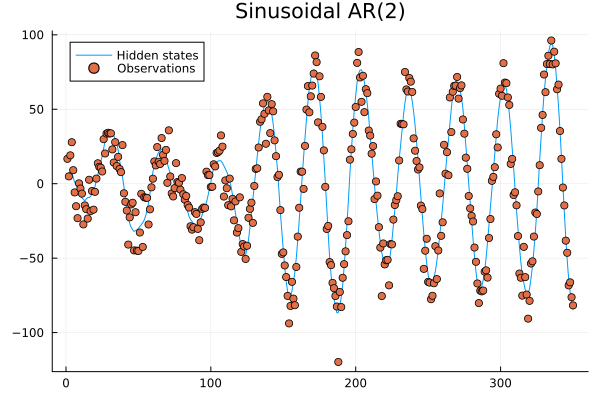

In [18]:
# Generate coefficients
predictions_coefficients = generate_sinusoidal_coefficients(f = 0.03)

# Generate dataset
predictions_dataset = generate_synthetic_dataset(n = 350, θ = predictions_coefficients, τ = 1.0, γ = 0.01)

# Plot dataset
plot_synthetic_dataset(dataset = predictions_dataset, title = "Sinusoidal AR(2)")

We can use the same model as before to automatically infer the coefficients of the sinusoidal pattern and predict the future values in the following way:

In [19]:
number_of_predictions = 100

predictions_states, predictions_observations = predictions_dataset

# We inject `missing` values to the observations to simulate 
# the future values that we want to predict
predictions_observations_with_predictions = vcat(
    predictions_observations,
    [ missing for _ in 1:number_of_predictions ]
)

# It is better to use `UnfactorizedData` for prediction
predictions_result = infer(
    model          = lar_multivariate(order = 2, γ = 0.01), 
    data           = (y = UnfactorizedData(predictions_observations_with_predictions), ),
    constraints    = ar_constraints(),
    meta           = ar_meta(2),
    initialization = ar_init(2),
    options        = (limit_stack_depth = 500, ),
    returnvars     = (x = KeepLast(), τ = KeepEach(), θ = KeepEach()),
    free_energy    = false,
    iterations     = 20
)

Inference results:
  Posteriors       | available for (τ, θ, x)
  Predictions      | available for (y)


**Note**: In the current version of RxInfer, the `free_energy` option is not supported for prediction. Thus we explicitly set it to `false`. However, we already verified that the inference procedure converges to the correct coefficients with the previous example.

### Prediction results

We first can check if the inference procedure has converged to the correct coefficients:

True coefficients: [1.9645745014573774, -1.0]
Inferred coefficients (mean value): [1.9607030556383294, -0.9972480850526085]


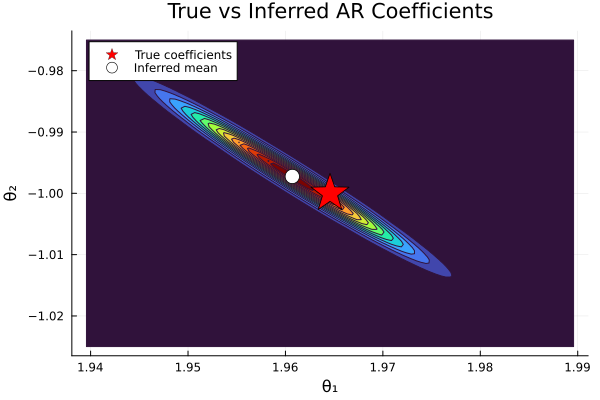

In [20]:
# Extract the inferred coefficients (mean of posterior)
inferred_coefficients = predictions_result.posteriors[:θ][end]

println("True coefficients: ", predictions_coefficients)
println("Inferred coefficients (mean value): ", mean(inferred_coefficients))

μ_true = predictions_coefficients
μ_inferred = mean(inferred_coefficients)

# Create grid of points
x = range(μ_true[1]-0.025, μ_true[1]+0.025, length=100)
y = range(μ_true[2]-0.025, μ_true[2]+0.025, length=100)

# Create contour plot
coefficients_plot = contour(x, y, (x, y) -> pdf(inferred_coefficients, [x, y]), 
    fill=true, 
    title="True vs Inferred AR Coefficients",
    xlabel="θ₁",
    ylabel="θ₂",
    levels = 14, 
    color=:turbo,
    colorbar = false
)

# Add point for true coefficients
scatter!(coefficients_plot, [μ_true[1]], [μ_true[2]], 
    label="True coefficients",
    marker=:star,
    markersize=20,
    color=:red
)

# Add point for inferred mean
scatter!(coefficients_plot, [μ_inferred[1]], [μ_inferred[2]], 
    label="Inferred mean",
    markersize=8,
    color=:white
)

Now let's visualize our prediction results to see how well our model captures the underlying temporal patterns. By plotting the predicted values against the actual test data, we can immediately assess the quality of our forecasts. Pay special attention to the confidence intervals (shaded regions) surrounding our predictions – these represent our model's uncertainty with propagated uncertainty from the inferred coefficients. 

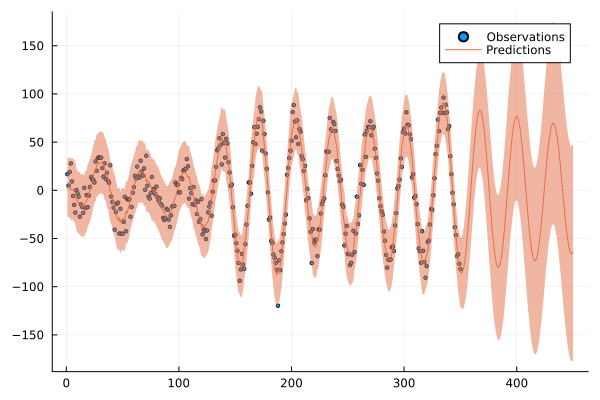

In [21]:
predictions_posterior_states = predictions_result.predictions[:y][end]

predictions_posterior_states_mean = mean.(predictions_posterior_states)
predictions_posterior_states_std = std.(predictions_posterior_states)

pred_p = scatter(predictions_observations, label="Observations", ms=2)
pred_p = plot!(pred_p, predictions_posterior_states_mean, ribbon=3predictions_posterior_states_std, label="Predictions")


Wide intervals suggest high uncertainty, while narrow ones indicate confidence in specific outcomes. When forecasting with AR models, several limitations deserve attention. First, AR models inherently assume that future patterns will resemble past ones - a tenuous assumption during regime changes or external shocks. Second, uncertainty compounds rapidly with prediction horizon; while one-step-ahead forecasts may appear precise, multi-step predictions quickly develop wide confidence intervals that reflect the model's decreasing predictive power.

To put it in the comparison, we could also use the inferred parameters to predict the future values using the inferred coefficients and the precision parameter. This approach however, will not yield the uncertainty estimates that we get from the inference procedure.

In [22]:
function predict_manual(; number_of_predictions, coefficients, precision, first_state, rng = StableRNG(42))
    states = [ first_state ]
    for i in 1:(number_of_predictions + 1)
        next_x     = rand(rng, NormalMeanPrecision(dot(coefficients, states[end]), precision))
        next_state = vcat(next_x, states[end][1:end-1])
        push!(states, next_state)
    end
    return states[2:end]
end

predict_manual (generic function with 1 method)

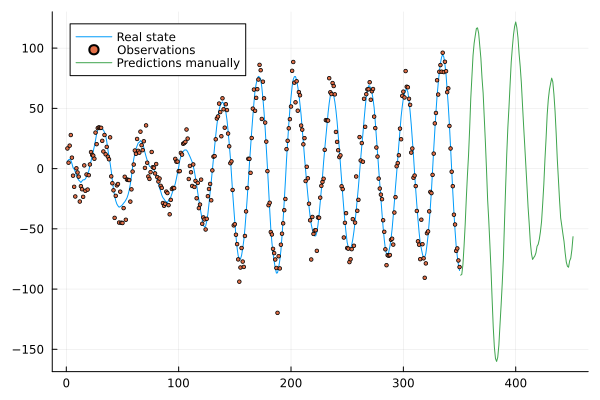

In [23]:
predicted_manually = predict_manual(; 
    number_of_predictions = number_of_predictions, 
    coefficients = predictions_coefficients, 
    precision = 0.1, 
    first_state = predictions_states[end]
)

plot(1:length(predictions_states), first.(predictions_states), label = "Real state")
scatter!(1:length(predictions_observations), first.(predictions_observations), label = "Observations", ms = 2)
plot!((length(predictions_observations)+1):length(predictions_observations) + number_of_predictions + 1, first.(predicted_manually), label = "Predictions manually")

Let's plot both predictions together to see the difference:

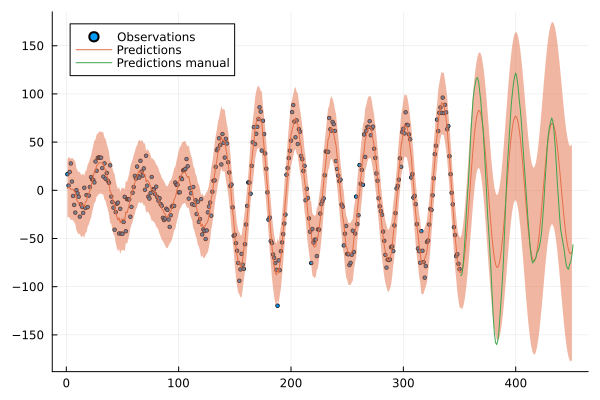

In [24]:
pred_p_manual = scatter(predictions_observations, label="Observations", ms=2)
pred_p_manual = plot!(pred_p_manual, predictions_posterior_states_mean, ribbon=3predictions_posterior_states_std, label="Predictions")
pred_p_manual = plot!(pred_p_manual, (length(predictions_observations)+1):length(predictions_observations) + number_of_predictions + 1, first.(predicted_manually), label = "Predictions manual")

We can see that manual prediction calculations, while computationally simpler, lack the crucial uncertainty quantification that we get from a proper Bayesian inference procedure. Additionally, the predictive power of an AR process directly relates to its order N - higher orders can capture more complex temporal dependencies and longer memory effects, but at the cost of potential overfitting. An AR(2) process can only predict based on the immediate previous observation, creating simple exponential trends, while an AR(5) can detect and forecast more intricate patterns like seasonal oscillations or cyclical behaviors. However, this improved predictive power comes with diminishing returns as N increases, requiring careful model selection to balance complexity against generalization ability for optimal forecasting performance.

# Stock Prices Dataset

Stock prices make for a challenging but instructive test case. They're notoriously difficult to predict, but often exhibit both short-term momentum (AR components) and characteristic responses to market shocks (MA components). We will use American Airlines stock data downloaded from [Kaggle](https://www.kaggle.com/code/purvasingh/time-series-analysis-with-arma-and-arima/data?select=all_stocks_5yr.csv)

In [25]:
x_df = CSV.read("aal_stock.csv", DataFrame)

1259×7 DataFrame
  Row │ date        open     high     low      close    volume    Name    
      │ Date        Float64  Float64  Float64  Float64  Int64     String3 
──────┼───────────────────────────────────────────────────────────────────
    1 │ 2013-02-08    15.07    15.12  14.63      14.75   8407500  AAL
    2 │ 2013-02-11    14.89    15.01  14.26      14.46   8882000  AAL
    3 │ 2013-02-12    14.45    14.51  14.1       14.27   8126000  AAL
    4 │ 2013-02-13    14.3     14.94  14.25      14.66  10259500  AAL
    5 │ 2013-02-14    14.94    14.96  13.16      13.99  31879900  AAL
    6 │ 2013-02-15    13.93    14.61  13.93      14.5   15628000  AAL
    7 │ 2013-02-19    14.33    14.56  14.08      14.26  11354400  AAL
    8 │ 2013-02-20    14.17    14.26  13.15      13.33  14725200  AAL
    9 │ 2013-02-21    13.62    13.95  12.9       13.37  11922100  AAL
   10 │ 2013-02-22    13.57    13.6   13.21      13.57   6071400  AAL
   11 │ 2013-02-25    13.6     13.76  13.0       13.02   7186400  AAL
  ⋮   │     ⋮          ⋮        ⋮        ⋮        ⋮        ⋮         ⋮
 1250 │ 2018-01-25    54.0     54.55  52.21      53.05  10223096  AAL
 1251 │ 2018-01-26    53.65    53.9   52.34      53.07   7066094  AAL
 1252 │ 2018-01-29    52.79    53.16  52.585     52.68   5953675  AAL
 1253 │ 2018-01-30    52.45    53.05  52.36      52.59   4741808  AAL
 1254 │ 2018-01-31    53.08    54.71  53.0       54.32   5962937  AAL
 1255 │ 2018-02-01    54.0     54.64  53.59      53.88   3623078  AAL
 1256 │ 2018-02-02    53.49    53.99  52.03      52.1    5109361  AAL
 1257 │ 2018-02-05    51.99    52.39  49.75      49.76   6878284  AAL
 1258 │ 2018-02-06    49.32    51.5   48.79      51.18   6782480  AAL
 1259 │ 2018-02-07    50.91    51.98  50.89      51.4    4845831  AAL
                                                         1238 rows omitted

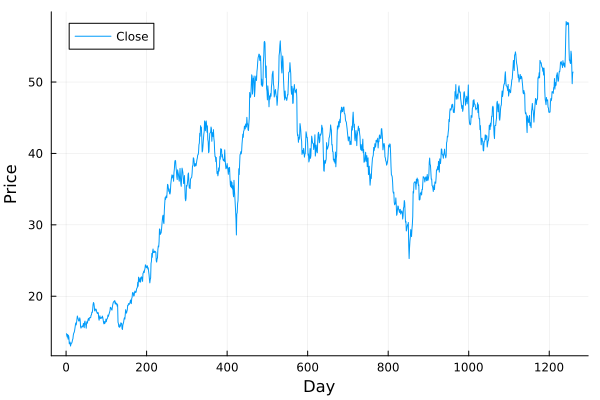

In [26]:
# We will use "close" column
x_data = filter(!ismissing, x_df[:, 5])

# Plot data
plot(x_data, xlabel="Day", ylabel="Price", label="Close")

### Preparing the dataset for inference and prediction 

To validate the inference and prediction results we will also split our dataset into two parts "observed" and "to_predict", which commonly also reffered as to "train" and "test" sets.

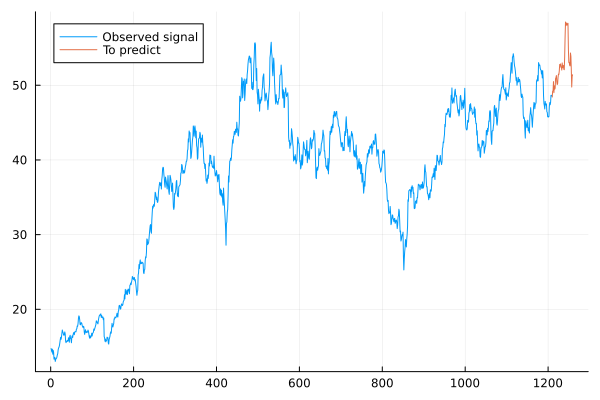

In [50]:
observed_size = length(x_data) - 50

# Observed part
x_observed    = Float64.(x_data[1:observed_size])

# We need to predict this part
x_to_predict   = Float64.(x_data[observed_size+1:end])

x_observed_length   = length(x_observed)
x_to_predict_length = length(x_to_predict)

plot(1:x_observed_length, x_observed, label = "Observed signal")
plot!((x_observed_length + 1):(x_observed_length + x_to_predict_length), x_to_predict, label = "To predict")

We can use the same model as before for the stock prices dataset. Let's however put the model to the ultimate test and use `AR(50)` to predict the future values. 

In [51]:
stock_observations_with_predictions = vcat(
    x_observed,
    [ missing for _ in 1:length(x_to_predict) ]
)

stock_predictions_result = infer(
    model          = lar_multivariate(order = 50, γ = 1.0), 
    data           = (y = UnfactorizedData(stock_observations_with_predictions), ),
    constraints    = ar_constraints(),
    meta           = ar_meta(50),
    initialization = ar_init(50),
    options        = (limit_stack_depth = 500, ),
    returnvars     = (x = KeepLast(), τ = KeepEach(), θ = KeepEach()),
    free_energy    = false,
    iterations     = 20
)

Inference results:
  Posteriors       | available for (τ, θ, x)
  Predictions      | available for (y)


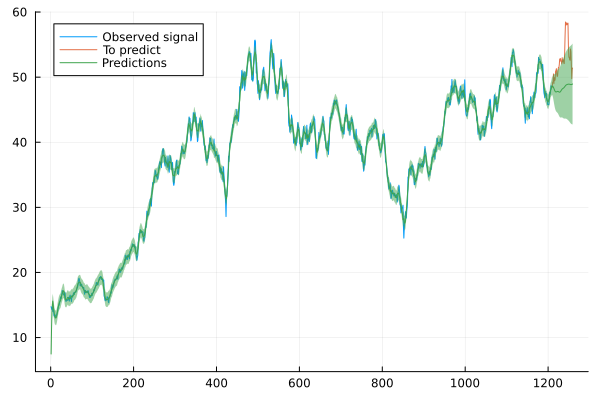

In [52]:
plot(1:x_observed_length, x_observed, label = "Observed signal")
plot!((x_observed_length + 1):(x_observed_length + x_to_predict_length), x_to_predict, label = "To predict")

stock_predictions = stock_predictions_result.predictions[:y][end]

plot!(mean.(stock_predictions), ribbon = std.(stock_predictions), label = "Predictions")

We can also plot it against the hidden states in the model and using only the first component of the hidden state:

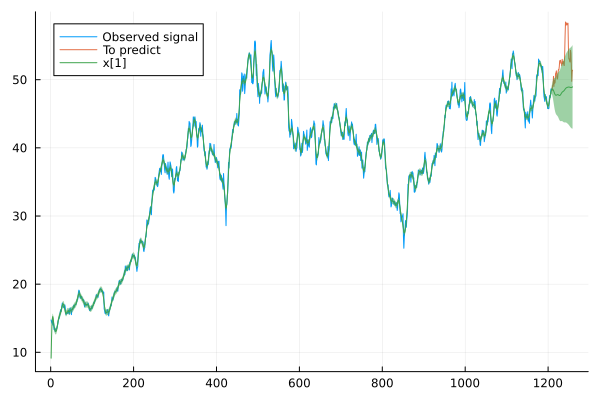

In [53]:
plot(1:x_observed_length, x_observed, label = "Observed signal")
plot!((x_observed_length + 1):(x_observed_length + x_to_predict_length), x_to_predict, label = "To predict")

stock_hidden_states = stock_predictions_result.posteriors[:x]

plot!(first.(mean.(stock_hidden_states)), ribbon = first.(std.(stock_hidden_states)), label = "x[1]")

# Autoregressive Moving Average Model

As a final touch, we will implement a **fully Bayesian** version of ARMA model. Autoregressive Moving Average (ARMA) models represent a powerful synthesis of two fundamental time series components: the autoregressive (AR) part, which captures how current values depend on past observations, and the moving average (MA) part, which models the persistence of random shocks. This combination makes ARMA models particularly well-suited for financial data like stock prices, where both momentum effects (AR) and reaction to news or market shocks (MA) influence price movements. In this example, we'll see how Bayesian inference with RxInfer can reveal these underlying dynamics while quantifying our uncertainty every step of the way.

## Mathematical Formulation of ARMA Model

Bayesian [ARMA model](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model#Applications) can be effectively implemeted in **RxInfer.jl**. For theoretical details on Varitional Inference for ARMA model, we refer the reader to the following [paper](https://ieeexplore.ieee.org/document/7798432). 
The Bayesian ARMA model can be written as follows:


$$\begin{aligned}
e_t &\sim \mathcal{N}(0, \gamma^{-1}) \\
\theta &\sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
\eta &\sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
\mathbf{h}_0 &\sim \mathcal{N}\left(\begin{bmatrix}
e_{-1} \\
e_{-2}
\end{bmatrix}, \mathbf{I}\right) \\
\mathbf{h}_t &= \mathbf{S}\mathbf{h}_{t-1} + \mathbf{c} e_{t-1} \\
\mathbf{x}_t &= \boldsymbol{\theta}^\top\mathbf{x}_{t-1} + \boldsymbol{\eta}^\top\mathbf{h}_{t} + e_t 
\end{aligned}$$

where shift matrix $\mathbf{S}$ is defined as

$$\begin{aligned}
\mathbf{S} = \begin{pmatrix}
0 & 0 \\
1 & 0 
\end{pmatrix}
\end{aligned}$$

In [31]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
        S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [32]:
shift(2)

2×2 Matrix{Float64}:
 0.0  0.0
 1.0  0.0

and unit vector $\mathbf{c}$: 

$$\begin{aligned}
\mathbf{c}=[1, 0]
\end{aligned}$$ 

when MA order is $2$. In this way, $\mathbf{h}_t$ containing errors $e_t$ can be viewed as hidden state.

## Intractabilities in ARMA model

In short, the Bayesian ARMA model has two intractabilities: 
- induced by the multiplication of two Gaussian RVs, i.e., $\boldsymbol{\eta}^\top\mathbf{h}_{t}$, 
- induced by errors $e_t$ that prevents analytical update of precision parameter $\gamma$ (this can be easily seen when constructing the Factor Graph, i.e. there is a loop). 

Both problems can be easily resolved in **RxInfer.jl**, by creating a hybrid inference algorithm based on Loopy Variational Message Passing.

### ARMA model specification

The model specification is the trickiest part of this implementation. Note how we need to carefully define the relationship between observed values, latent states, and error terms. The ARMA model's loops create inference challenges that wouldn't exist in simpler models - this is why we need to specify proper initialization and factorization constraints to avoid convergence problems. For the `@meta` we will simply reuse the previously defined `ar_meta` function.

In [33]:
@model function ARMA(x, x_prev, priors, p_order, q_order)
    
    # arguments
    c = zeros(q_order); c[1] = 1.0;
    S = shift(q_order); # MA

    # set priors
    γ    ~ priors[:γ]
    η    ~ priors[:η]
    θ    ~ priors[:θ]
    τ    ~ priors[:τ]
    
    h[1] ~ priors[:h]
    z[1] ~ AR(h[1], η, τ)
    e[1] ~ Normal(mean = 0.0, precision = γ)
    x[1] ~ dot(c, z[1]) + dot(θ, x_prev[1]) + e[1]

    for t in 1:length(x)-1
        h[t+1] ~ S * h[t] + c * e[t]
        z[t+1] ~ AR(h[t+1], η, τ)
        e[t+1] ~ Normal(mean = 0.0, precision = γ)
        x[t+1] ~ dot(c, z[t+1]) + dot(θ, x_prev[t+1]) + e[t+1]
    end
end

@constraints function arma_constraints()
    q(z, h, η, τ, γ,e) = q(z, h)q(η)q(τ)q(γ)q(e)
end

@initialization function arma_initialization(priors) 
    q(h)   = priors[:h]
    μ(h)   = priors[:h]
    q(γ)   = priors[:γ]
    q(τ)   = priors[:τ]
    q(η)   = priors[:η]
    q(θ)   = priors[:θ]
end

arma_initialization (generic function with 1 method)

In [34]:
p_order = 10 # AR
q_order = 4  # MA

4

### Inference with ARMA model 

Now, everything should be ready for the `infer` call from `RxInfer` on the stock prices dataset defined earlier.

In [35]:
priors  = (
    h = MvNormalMeanPrecision(zeros(q_order), diageye(q_order)),
    γ = GammaShapeRate(1e4, 1.0),
    τ = GammaShapeRate(1e2, 1.0),
    η = MvNormalMeanPrecision(ones(q_order), diageye(q_order)),
    θ = MvNormalMeanPrecision(zeros(p_order), diageye(p_order))
)

arma_x_data = Float64.(x_data[p_order+1:end])[1:observed_size]
arma_x_prev_data = [Float64.(x_data[i+p_order-1:-1:i]) for i in 1:length(x_data)-p_order][1:observed_size]

result = infer(
    model = ARMA(priors=priors, p_order = p_order, q_order = q_order), 
    data  = (x = arma_x_data, x_prev = arma_x_prev_data),
    initialization = arma_initialization(priors),
    constraints    = arma_constraints(),
    meta           = ar_meta(q_order),
    returnvars     = KeepLast(),
    iterations     = 20,
    options        = (limit_stack_depth = 400, ),
)

Inference results:
  Posteriors       | available for (γ, e, τ, h, z, θ, η)


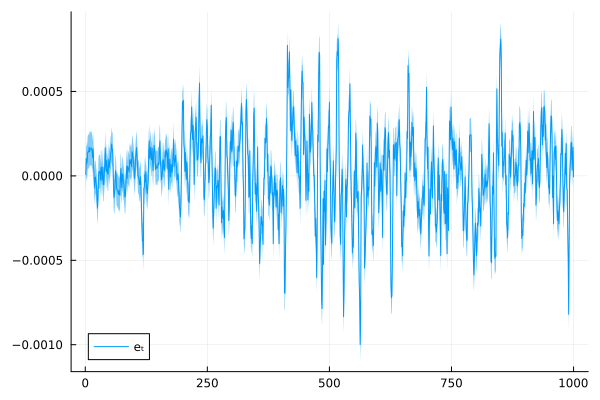

In [36]:
plot(mean.(result.posteriors[:e]), ribbon = var.(result.posteriors[:e][end]), label = "eₜ")

What we've seen in this example is more than just a stock price forecast - it's a demonstration of how modern probabilistic programming with RxInfer enables sophisticated time series modeling with relatively concise code. The same techniques can be applied across domains from economics to engineering, wherever systems exhibit both memory effects and response to external shocks. And most importantly, the Bayesian approach gives us a principled way to quantify uncertainty in our predictions - essential for robust decision-making in any domain.